In [ ]:
'''
Dataset Info.

train.csv [파일]
PRODUCT_ID : 제품의 고유 ID
Y_Class : 제품 품질 상태(Target) 
0 : 적정 기준 미달 (부적합)
1 : 적합
2 : 적정 기준 초과 (부적합)
Y_Quality : 제품 품질 관련 정량적 수치
TIMESTAMP : 제품이 공정에 들어간 시각
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'V' 존재)
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


test.csv [파일]
PRODUCT_ID : 제품의 고유 ID
TIMESTAMP : 제품이 공정에 들어간 시각
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


sample_submission.csv [파일] - 제출 양식
PRODUCT_ID : 제품의 고유 ID
Y_Class : 예측한 제품 품질 상태
0 : 적정 기준 미달 (부적합)
1 : 적합
2 : 적정 기준 초과 (부적합)

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.
'''

In [204]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')

In [205]:
def cnt_plot(data, col,  hue, title):
    plt.rc('font', family='Malgun Gothic')
    plt.rc("axes",unicode_minus=False)
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=40)
    ax=sns.countplot(x=col, hue=hue ,data = data, palette='Reds')
    for p in ax.patches:
        ax.annotate("%.0f"%p.get_height(),(p.get_x() + p.get_width()/2, p.get_height()),
                   ha='center', va='center', fontsize=11, color='black', xytext=(0,10),
                   textcoords='offset points')
    plt.title(title)
    plt.show()

In [206]:
def cyclical_feature(df): 
    df['sin_time'] = np.sin(2*np.pi*(df.HOUR*60+df.MIN)/60)
    df['cos_time'] = np.cos(2*np.pi*(df.HOUR*60+df.MIN)/60)

In [207]:
def cyclical_feature(df): 
    df['sin_time'] = np.sin(2*np.pi*df.HOUR/24)
    df['cos_time'] = np.cos(2*np.pi*df.HOUR/24)

In [208]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [216]:
test.tail(3)

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
307,TEST_307,2022-11-05 16:47,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,TEST_308,2022-11-05 20:53,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,TEST_309,2022-11-05 21:01,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
train.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN


In [211]:
train.iloc[:,1:].duplicated().sum()

0

# TIMESTAMP SPLIT

In [212]:
train['YEAR'] = train['TIMESTAMP'].str.split('-').str[0].astype('int')
train['MONTH'] = train['TIMESTAMP'].str.split('-').str[1].astype('int')
train['DAY'] = train['TIMESTAMP'].str.split('-').str[2]
train['DAY'] = train['DAY'].str.split().str[0].astype('int')
train['TIME'] = train['TIMESTAMP'].str.split().str[1]
train['HOUR'] = train['TIME'].str.split(':').str[0].astype('int')
train['TIME_MIN'] = train['TIME'].str.split(':').str[1].astype('int')+train['HOUR']*60

In [213]:
cyclical_feature(train)

In [214]:
train.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2874,X_2875,YEAR,MONTH,DAY,TIME,HOUR,TIME_MIN,sin_time,cos_time
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,2022,6,13,5:14,5,314,0.965926,0.258819
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,2022,6,13,5:22,5,322,0.965926,0.258819
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,2022,6,13,5:30,5,330,0.965926,0.258819


In [215]:
train['TIME_MIN'].nunique()

477

# 유니크값

In [178]:
train['LINE'].unique()

array(['T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305'],
      dtype=object)

In [179]:
train['PRODUCT_CODE'].unique()

array(['A_31', 'T_31', 'O_31'], dtype=object)

In [180]:
train['YEAR'].unique()

array([2022])

In [181]:
train['DAY'].unique()

array([13, 14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 15, 17, 18, 28, 30, 31])

In [182]:
train['HOUR'].unique()

array([ 5,  6,  7,  8,  9, 23, 20, 21, 17,  3,  4, 12, 10, 15,  1, 22, 18,
       16,  0, 19, 14,  2, 13, 11])

In [183]:
train['MIN'].unique()

array([14, 22, 30, 39, 47, 55,  3, 11, 19, 28, 36, 44, 52,  0,  8, 17, 25,
       33, 41, 49, 58, 53,  1, 46, 20, 18, 26, 31,  6, 37, 45, 34, 24, 32,
       42, 50,  2,  5, 13, 59, 38, 29, 54,  7, 15, 57, 43, 48, 56, 21, 12,
       35, 40, 23, 16,  9,  4, 10, 51, 27])

# 결측치관련
1. 결측비율 100% 인 경우 제거 -> 82개

In [184]:
train.isnull().sum()/len(train)

PRODUCT_ID    0.0
Y_Class       0.0
Y_Quality     0.0
TIMESTAMP     0.0
LINE          0.0
             ... 
TIME          0.0
HOUR          0.0
MIN           0.0
sin_time      0.0
cos_time      0.0
Length: 2889, dtype: float64

In [185]:
col_list = train.columns
nan_list = []
nan_cnt = []
nan_col = []
full_list = []
for col in col_list:
    if train[col].isnull().sum() == 0 :
        full_list.append(col)
        continue
    nan_list.append([col, train[col].isnull().sum()])
    nan_cnt.append(train[col].isnull().sum())
    nan_col.append(col)

In [186]:
set(nan_cnt)

{249,
 250,
 349,
 350,
 351,
 365,
 423,
 424,
 469,
 478,
 479,
 480,
 488,
 494,
 498,
 499,
 504,
 511,
 520,
 528,
 536,
 539,
 546,
 556,
 559,
 565,
 575,
 588,
 592,
 598}

In [137]:
len(nan_col)

2875

In [138]:
'''모든값이 결측값이면 제거'''

del_col = []
for col in nan_list :
    if col[1] == 598 :
        del_col.append(col[0])
train = train.drop(columns=del_col)
train.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2870,X_2871,YEAR,MONTH,DAY,TIME,HOUR,MIN,sin_time,cos_time
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,77.77,NaN,2022,6,13,5:14,5,14,0.965926,0.258819
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,72.55,NaN,2022,6,13,5:22,5,22,0.965926,0.258819
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,78.35,NaN,2022,6,13,5:30,5,30,0.965926,0.258819


In [ ]:
# fill_company_mean = lambda g : g.fillna(g.mean())
# data = data.groupby('company').apply(fill_company_mean)

In [147]:
list_249=[]
for col in nan_list:
    if col[1]==249 :
        list_249.append(col)

# 시각화

### 1. Y_Class 관련

- 6-7 월은 기준초과의 비율이 높은편, 8-9월은 기준 미달 비율이 높은 편 -> 6&7/8&9 피처별 차이 봐야할ㄷㅅ듯

- A 라인은 6월에서 9월로 이동할수록 기준 누락 늘어남 , T 라인은 전체적으로 안정적

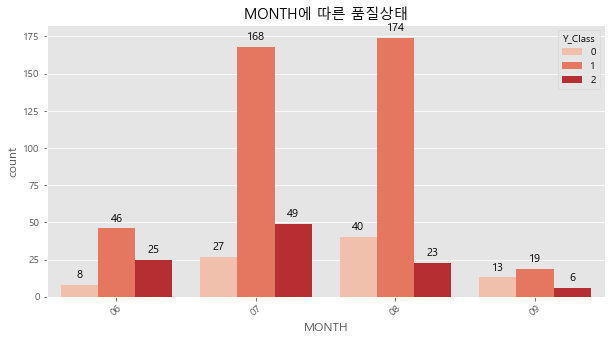

In [88]:
cnt_plot(train, 'MONTH', 'Y_Class' , 'MONTH에 따른 품질상태')

'''
6-7 월은 기준초과의 비율이 높은편, 8-9월은 기준 미달 비율이 높은 편 -> 6&7/8&9 피처별 차이 봐야할ㄷㅅ듯

가설1. 날씨에 영향을 받았다.
가설2. 6-7월에 생산된 제품들이 전체적으로 기준 초과가 높아서 8월부터 생산과정에 변화를 주었더니 기준 미달 비율이 높아졌다.

'''

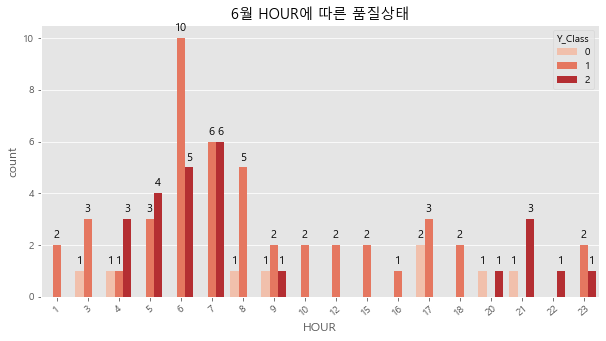

In [97]:
cnt_plot(train[train['MONTH']==6].sort_values(by=['HOUR']).reset_index(drop=True), 'HOUR', 'Y_Class' , '6월 HOUR에 따른 품질상태')

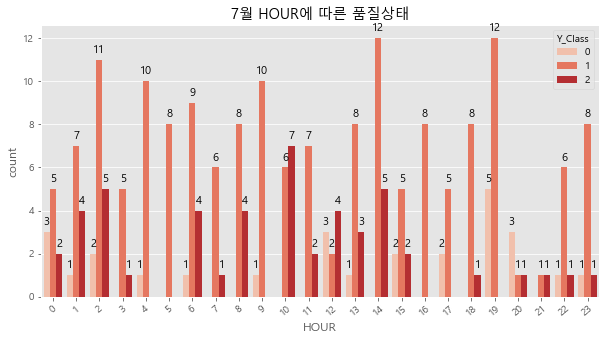

In [98]:
cnt_plot(train[train['MONTH']==7].sort_values(by=['HOUR']).reset_index(drop=True), 'HOUR', 'Y_Class' , '7월 HOUR에 따른 품질상태')

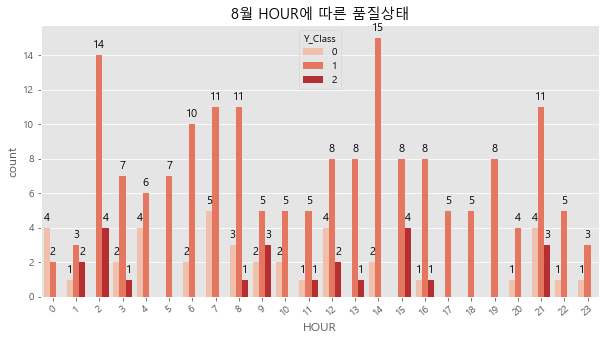

In [99]:
cnt_plot(train[train['MONTH']==8].sort_values(by=['HOUR']).reset_index(drop=True), 'HOUR', 'Y_Class' , '8월 HOUR에 따른 품질상태')

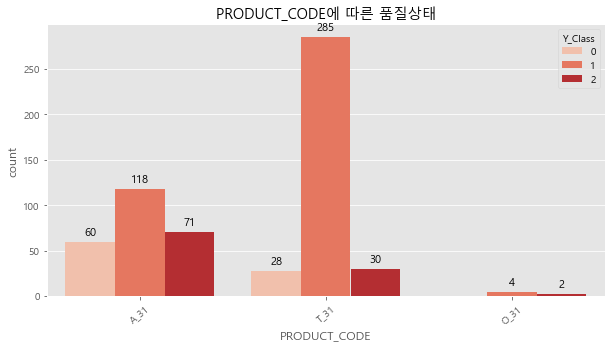

In [139]:
cnt_plot(train, 'PRODUCT_CODE', 'Y_Class' , 'PRODUCT_CODE에 따른 품질상태')
'''
O_31은 9월에 생겼다.
'''

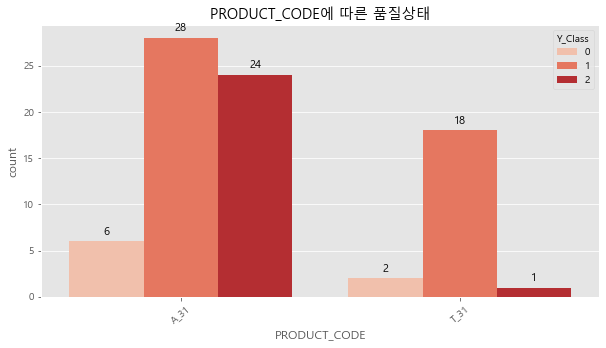

In [142]:
cnt_plot(train[train['MONTH']==6], 'PRODUCT_CODE', 'Y_Class' , 'PRODUCT_CODE에 따른 품질상태')

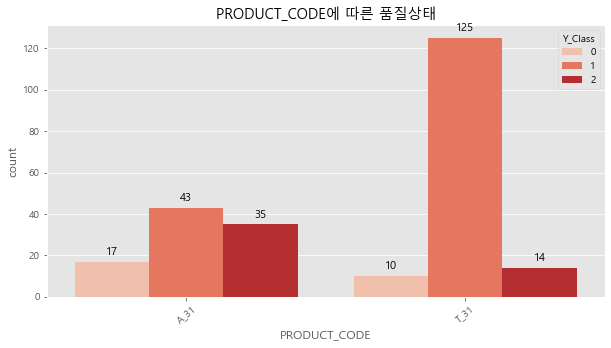

In [141]:
cnt_plot(train[train['MONTH']==7], 'PRODUCT_CODE', 'Y_Class' , 'PRODUCT_CODE에 따른 품질상태')

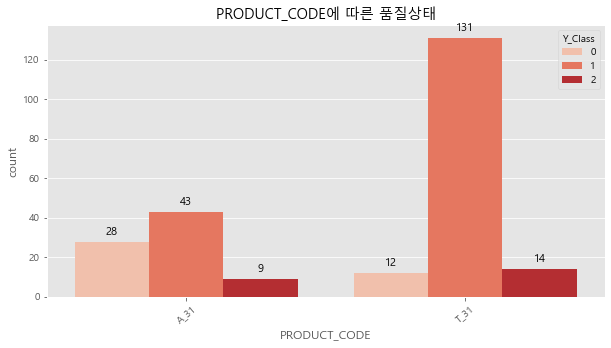

In [140]:
cnt_plot(train[train['MONTH']==8], 'PRODUCT_CODE', 'Y_Class' , 'PRODUCT_CODE에 따른 품질상태')

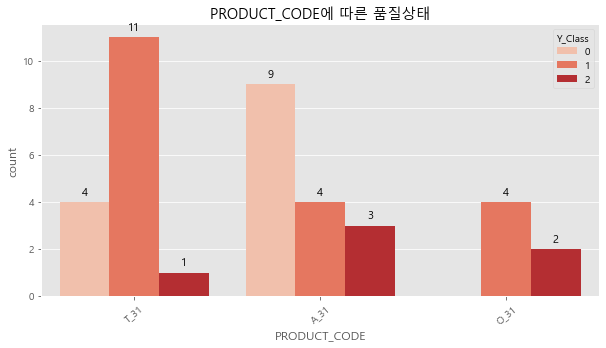

In [143]:
cnt_plot(train[train['MONTH']==9], 'PRODUCT_CODE', 'Y_Class' , 'PRODUCT_CODE에 따른 품질상태')

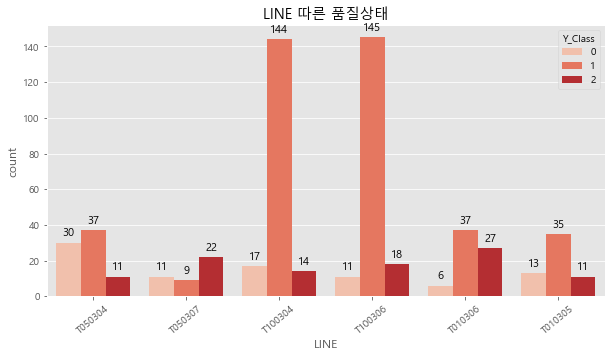

In [202]:
cnt_plot(train, 'LINE', 'Y_Class' , 'LINE 따른 품질상태')